# 04d - Vertex AI - AutoML for Global Forecasting with Deep Learning - multiple parallel scenarios

A newer way to fit forecast models to time series data is by using a deep learning approach with neural networks. This approah can have added success because it is a global forecast, it not only sees and individual time series but also sees across many time series and can learn together from correlation.  This approach can also include covariate features that may only be known in the past or may also be available at forecast time. Vertex AI AutoML forecasting will do automatic feature engineering, model architecture search and hyperparameter tuning specific to time series data.  This method using a set of data between the training data and the test data called validation data to time series specific approachs using deep learning architectures.  

In the `04c` notebook we used the Vertex AI Python Client to automate the process of using Vertex AI AutoML forecasting.  One of the parameters for a forecast scenario is the context window - how far back the model looks in training and forecasting for predictive patterns.  There are some tips for choosing an initial context window and iterating to an optimal value provided [here](https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular#context-window).  To speed up this iteration we will conduct multiple scenarios, each with a different context window, all asynchonously - in parallel.  

After all the scenarios complete we will use BigQuery SQL queries to combine the results of `04b`, `04c` and this notebooks scenarios and calcualte custom metrics to compare and pick the best context window overall, and by series.

### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery
- 04b - Vertex AI - AutoML for Global Forecasting with Deep Learning - In GCP Console (no code)
- 04c - 04c - Vertex AI - AutoML for Global Forecasting with Deep Learning - with Python client (code)

### Overview:
- Setup
- Create Dataset
- Train Forecasting Model with AutoML - Multiple Scenarios
    - Function to Create AutoML Forecasting Jobs and Run Them
- Review Scenarios
    - Review Custom Metrics with SQL
    - Find Context Window Scenario with Best pMAE score (minimum)
    - Create BigQuery Table with Best Forecast For Each Series based on pMAE
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve the Forecasting Data (raw series)
    - Visualize the Time Series with Forecast

### Resources:
- [Train an AutoML model (Vertex AI API)](https://cloud.google.com/vertex-ai/docs/training/automl-api#forecasting)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Optimization objectives for tabular AutoML models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)
- [Evaluation metrics returned by Vertex AI](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#evaluation_metrics_returned_by)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04d_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04d_console.png">

---
## Setup

inputs:

In [85]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04d'

packages:

In [86]:
from google.cloud import bigquery
from google.cloud import aiplatform

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [87]:
bigquery = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

---
## Create Dataset (Link to BigQuery Table)

Reference for [`aiplatform.TimeSeriesDataset.create`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.TimeSeriesDataset.create)

In [4]:
dataset = aiplatform.TimeSeriesDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TimeSeriesDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TimeSeriesDataset backing LRO: projects/715288179162/locations/us-central1/datasets/4830308512447856640/operations/632839929004556288
INFO:google.cloud.aiplatform.datasets.dataset:TimeSeriesDataset created. Resource name: projects/715288179162/locations/us-central1/datasets/4830308512447856640
INFO:google.cloud.aiplatform.datasets.dataset:To use this TimeSeriesDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/4830308512447856640')


In [89]:
#dataset = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/7814110391348232192')

---
## Train Forecasting Model with AutoML - Multiple Scenarios

The goal here is to train a range of AutoML Forecasting Models on the same data using combination of forecast horizon and context window.  This is follow the guidance of [Considerations for setting the context window and forecast horizon](https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular#context-window).

The test data reflects a forecast horizon of 16 days which we want to keep for comparion to methods in other notebooks.  This leaves us with the option to change the context window in order to select the best scenario.  The first step is to double the contect window. Looking ahead we discover this actually makes for worse forecast.  This is understandable because this example data has multiple time series that are recently introduced bike stations.  This is a case were a shorter context window is likely to gain more recent and relevant forecasting information.  For this reason we consider these context windows to compare:

- Context Window = 14 - Notebook 04b
- Context Window = 28 - Notebook 04c
- Context Window = 7
- Context Window = 4
- Context Window = 2
- Context Window = 1
- Context Window = 0

Note, there is a default concurrent training job limit for Vertex AI AutoML of 5 jobs ([reference here](https://cloud.google.com/vertex-ai/docs/quotas#tabular)).  Here we are running 5 jobs but it we needed to run more we would have to wait for a job to complete or submit a quota increas ([reference here](https://cloud.google.com/vertex-ai/docs/quotas#quota_increases)).

### Function to Create AutoML Forecasting Jobs and Run Them

Reference for [`aiplatform.AutoMLForecastingTrainingJob`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob)

Reference for [`aiplatform.AutoMLForecastingTrainingJob.run`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob.run)

In [21]:
def scenario(ds, cw):
    column_specs = list(set(dataset.column_names) - set(['splits','start_station_name']))
    column_specs = dict.fromkeys(column_specs, 'auto')
    
    forecast_job = aiplatform.AutoMLForecastingTrainingJob(
        display_name = f'{NOTEBOOK}_{DATANAME}_CW{cw}',
        optimization_objective = "minimize-rmse",
        column_specs = column_specs,
        labels = {'notebook':f'{NOTEBOOK}', 'cw':f'{cw}'}
    )
    
    forecast = forecast_job.run(
        dataset = ds,
        target_column = "num_trips",
        time_column = "date",
        time_series_identifier_column = "start_station_name",
        unavailable_at_forecast_columns = ["num_trips",],
        available_at_forecast_columns = ["date",],
        forecast_horizon = 14,
        data_granularity_unit = "day",
        data_granularity_count = 1,
        predefined_split_column_name = "splits",
        context_window = cw,
        export_evaluated_data_items = True,
        export_evaluated_data_items_bigquery_destination_uri = f"bq://{PROJECT_ID}:{DATANAME}:{NOTEBOOK}_automl_cw{cw}",
        validation_options = "fail-pipeline",
        budget_milli_node_hours = 1000,
        model_display_name = f"{NOTEBOOK}_{DATANAME}_CW{cw}",
        model_labels = {'notebook':f'{NOTEBOOK}', 'cw':f'{cw}'},
        sync = False
    )
    
    return forecast

In [90]:
windows = [7, 4, 2, 1, 0]

In [23]:
scenarios = []
for w in windows:
    scenarios.append(scenario(dataset, w))

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2069897159741800448?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/866310159327035392?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/6681583178169188352?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8609123818683760640?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8960404589618659328?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPi

<img src="architectures/notebooks/04d_screenshots/train_1.png">

---
## Review Scenarios

### Review Custom Metrics with SQL
Compare results by series for each context window scenario in this notebook combined with `04b` and `04d`

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [96]:
query = f"""
WITH
    STACKS AS (
        SELECT *, 0 as CW FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw0` UNION ALL
        SELECT *, 1 as CW FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw1` UNION ALL
        SELECT *, 2 as CW FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw2` UNION ALL
        SELECT *, 4 as CW FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw4` UNION ALL
        SELECT *, 7 as CW FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw7` UNION ALL
        SELECT *, 14 as CW FROM `{PROJECT_ID}.{DATANAME}.04b_automl` UNION ALL
        SELECT *, 28 as CW FROM `{PROJECT_ID}.{DATANAME}.04c_automl`
    ),
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predited_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, CW, predicted_num_trips.value as predicted_num_trips
        FROM STACKS
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predited_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, CW, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, CW, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE
FROM DIFFS
GROUP BY start_station_name, CW, time_series_type
ORDER BY start_station_name, CW, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,CW,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,0,forecast,0.581057,44.700327,0.287991
1,Central Park North & Adam Clayton Powell Blvd,1,forecast,0.719211,47.852846,0.308302
2,Central Park North & Adam Clayton Powell Blvd,2,forecast,0.686290,50.100857,0.322785
3,Central Park North & Adam Clayton Powell Blvd,4,forecast,0.687601,50.011757,0.322211
4,Central Park North & Adam Clayton Powell Blvd,7,forecast,0.713553,54.070828,0.348362
...,...,...,...,...,...,...
79,W 82 St & Central Park West,2,forecast,0.416159,28.105321,0.304547
80,W 82 St & Central Park West,4,forecast,0.367648,25.885723,0.280495
81,W 82 St & Central Park West,7,forecast,0.365233,26.499178,0.287143
82,W 82 St & Central Park West,14,forecast,0.343071,25.404739,0.275284


### Find Context Window Scenario with Best pMAE score (minimum)

In [97]:
bestCW = customMetrics[customMetrics['pMAE'] == customMetrics.groupby(['start_station_name'])['pMAE'].transform('min')].reset_index()
bestCW

,index,start_station_name,CW,time_series_type,MAPE,MAE,pMAE
0,0,Central Park North & Adam Clayton Powell Blvd,0,forecast,0.581057,44.700327,0.287991
1,9,Central Park S & 6 Ave,2,forecast,0.418297,73.831314,0.226229
2,19,Central Park W & W 96 St,14,forecast,0.646452,23.388470,0.233718
3,25,Central Park West & W 100 St,7,forecast,0.945289,15.044341,0.379497
4,32,Central Park West & W 102 St,7,forecast,0.471665,10.068908,0.198822
5,35,Central Park West & W 68 St,0,forecast,0.362839,35.311545,0.233080
6,44,Central Park West & W 72 St,2,forecast,0.463650,39.398071,0.222685
7,52,Central Park West & W 76 St,4,forecast,0.351310,23.557091,0.215133
8,56,Central Park West & W 85 St,0,forecast,1.061449,43.800394,0.348412
9,67,Grand Army Plaza & Central Park S,7,forecast,0.444591,36.884081,0.169612


### Create BigQuery Table with Best Forecast For Each Series based on pMAE

In [99]:
tableMap = {
    0 : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw0',
    1 : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw1',
    2 : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw2',
    4 : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw4',
    7 : f'{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_cw7',
    14 : f'{PROJECT_ID}.{DATANAME}.04b_automl',
    28 : f'{PROJECT_ID}.{DATANAME}.04c_automl',
}

In [100]:
query = """"""
for i, row in bestCW.iterrows():
    if i> 0: query += f""" UNION ALL\n"""
    query += f"""SELECT *, {row['CW']} as CW FROM `{tableMap[row['CW']]}` WHERE start_station_name = '{row['start_station_name']}'
    """
    
query = f"""CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best` AS
""" + query + """ORDER BY start_station_name, date
"""
print(query)

CREATE OR REPLACE TABLE `statmike-demo3.citibikes.04d_automl_best` AS
SELECT *, 0 as CW FROM `statmike-demo3.citibikes.04d_automl_cw0` WHERE start_station_name = 'Central Park North & Adam Clayton Powell Blvd'
     UNION ALL
SELECT *, 2 as CW FROM `statmike-demo3.citibikes.04d_automl_cw2` WHERE start_station_name = 'Central Park S & 6 Ave'
     UNION ALL
SELECT *, 14 as CW FROM `statmike-demo3.citibikes.04b_automl` WHERE start_station_name = 'Central Park W & W 96 St'
     UNION ALL
SELECT *, 7 as CW FROM `statmike-demo3.citibikes.04d_automl_cw7` WHERE start_station_name = 'Central Park West & W 100 St'
     UNION ALL
SELECT *, 7 as CW FROM `statmike-demo3.citibikes.04d_automl_cw7` WHERE start_station_name = 'Central Park West & W 102 St'
     UNION ALL
SELECT *, 0 as CW FROM `statmike-demo3.citibikes.04d_automl_cw0` WHERE start_station_name = 'Central Park West & W 68 St'
     UNION ALL
SELECT *, 2 as CW FROM `statmike-demo3.citibikes.04d_automl_cw2` WHERE start_station_name = 'Centra

In [101]:
job = bigquery.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

1.553

---
## Results

### Retrieve Test Data (best context window prepared above)

In [102]:
query = f"""
WITH
    RAW AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, CW, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best`
    ),
    LEAD AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM RAW
    ),
    LEFTSIDE AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD
        GROUP BY start_station_name, date
    )
SELECT *
FROM LEFTSIDE
LEFT OUTER JOIN LEAD
USING (start_station_name, date, prediction_lead_days)
"""
autoML = bigquery.query(query = query).to_dataframe()
autoML

,start_station_name,date,prediction_lead_days,predicted_on_date,num_trips,splits,CW,predicted_num_trips
0,Central Park North & Adam Clayton Powell Blvd,2016-09-17,0,2016-09-17,269,TEST,0,194.988358
1,Central Park North & Adam Clayton Powell Blvd,2016-09-18,0,2016-09-18,272,TEST,0,188.883987
2,Central Park North & Adam Clayton Powell Blvd,2016-09-19,0,2016-09-19,39,TEST,0,136.328735
3,Central Park North & Adam Clayton Powell Blvd,2016-09-20,0,2016-09-20,120,TEST,0,130.598953
4,Central Park North & Adam Clayton Powell Blvd,2016-09-21,0,2016-09-21,164,TEST,0,129.928741
...,...,...,...,...,...,...,...,...
154,W 82 St & Central Park West,2016-09-26,0,2016-09-26,102,TEST,14,92.901421
155,W 82 St & Central Park West,2016-09-27,0,2016-09-27,105,TEST,14,81.744499
156,W 82 St & Central Park West,2016-09-28,0,2016-09-28,72,TEST,14,84.695183
157,W 82 St & Central Park West,2016-09-29,0,2016-09-29,143,TEST,14,84.765869


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [103]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, CW, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, CW, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, CW, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY start_station_name, CW, time_series_type
ORDER BY start_station_name, CW, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,CW,time_series_type,MAPE,MAE,pMAE,n
0,Central Park North & Adam Clayton Powell Blvd,0,forecast,0.581057,44.700327,0.287991,14
1,Central Park S & 6 Ave,2,forecast,0.418297,73.831314,0.226229,14
2,Central Park W & W 96 St,14,forecast,0.646452,23.388470,0.233718,14
3,Central Park West & W 100 St,7,forecast,0.945289,15.044341,0.379497,14
4,Central Park West & W 102 St,7,forecast,0.471665,10.068908,0.198822,14
5,Central Park West & W 68 St,0,forecast,0.362839,35.311545,0.233080,14
6,Central Park West & W 72 St,2,forecast,0.463650,39.398071,0.222685,13
7,Central Park West & W 76 St,4,forecast,0.351310,23.557091,0.215133,14
8,Central Park West & W 85 St,0,forecast,1.061449,43.800394,0.348412,7
9,Grand Army Plaza & Central Park S,7,forecast,0.444591,36.884081,0.169612,13


Overall Metrics:

In [104]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, CW, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_best`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, CW, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type    
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,n
0,forecast,0.515787,31.757984,0.237122,159


### Retrieve the Forecasting Data (raw series)

In [105]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [106]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize The Time Series with Forecast

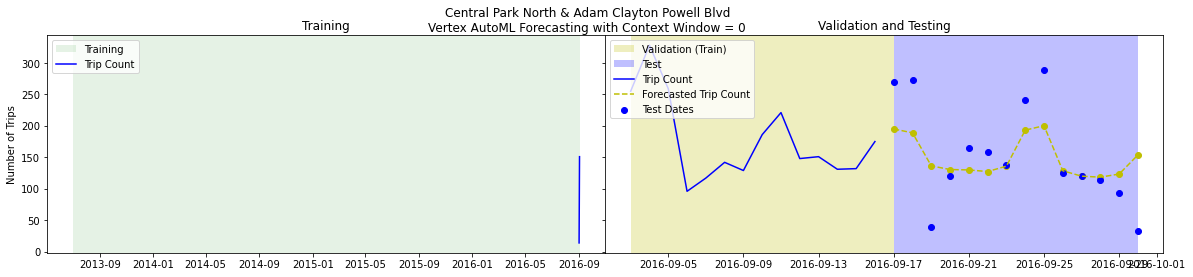

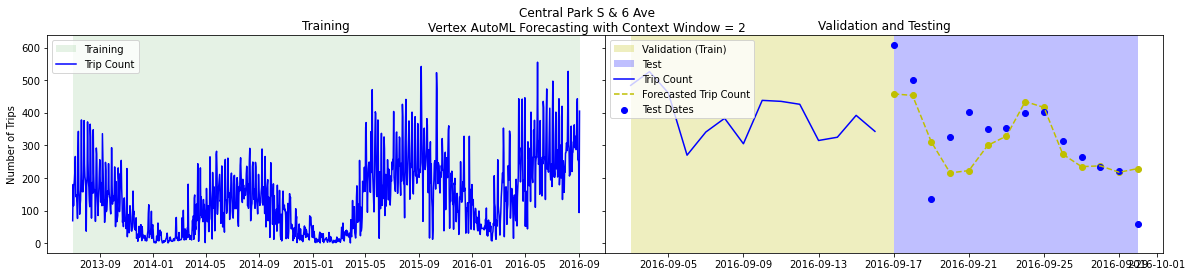

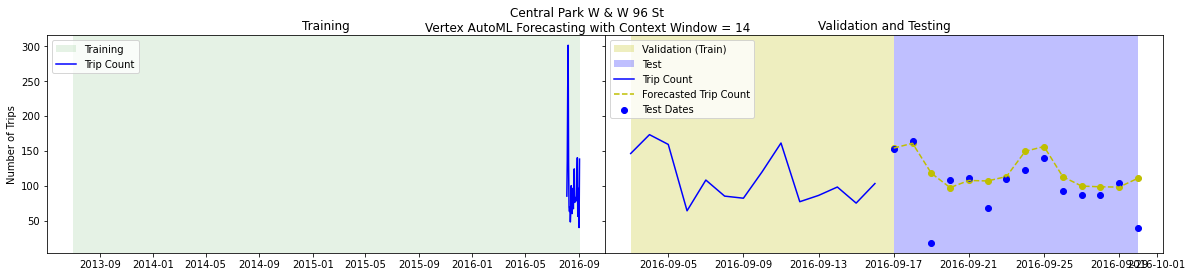

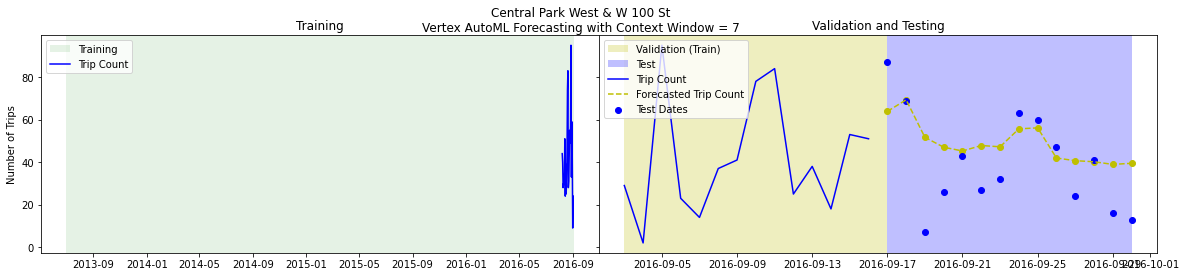

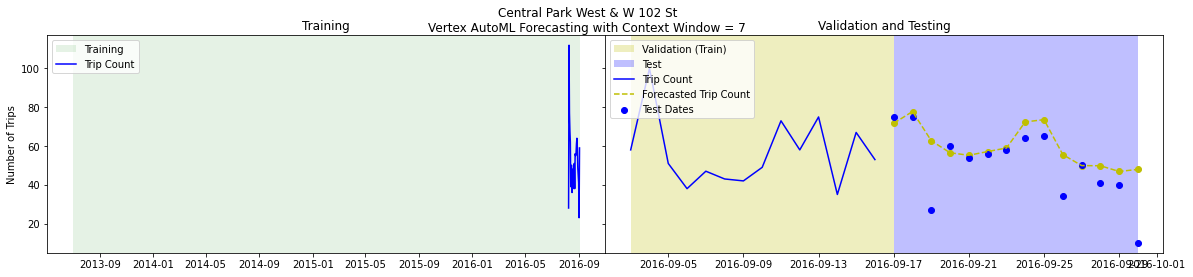

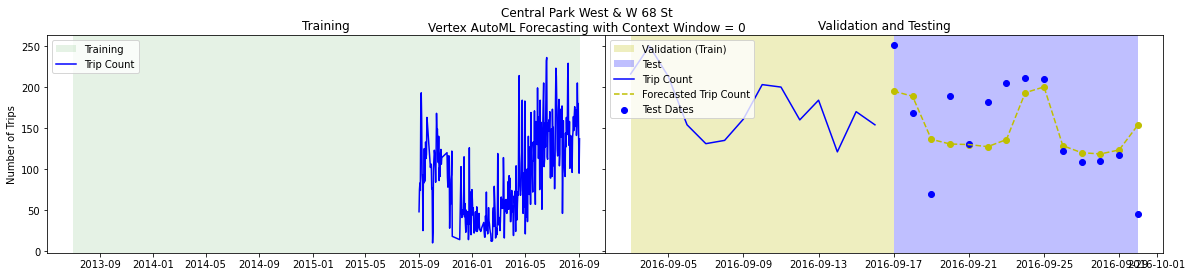

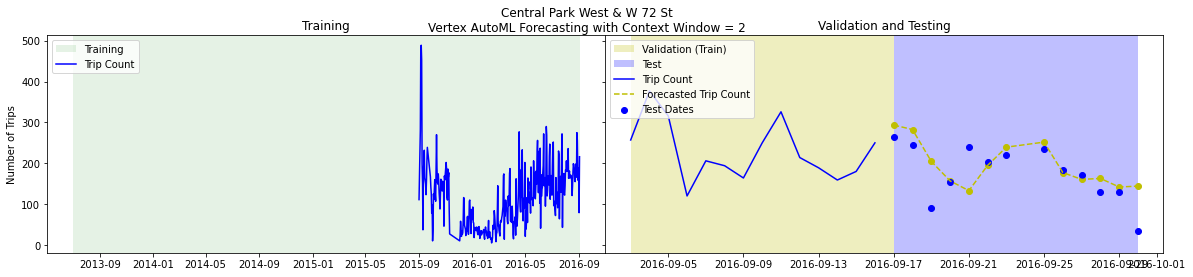

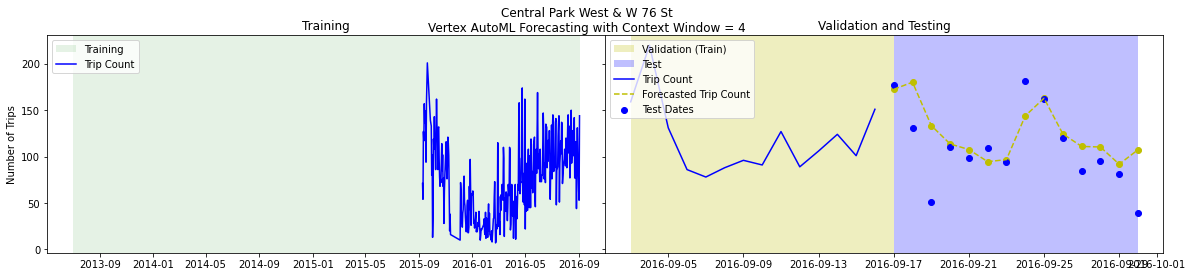

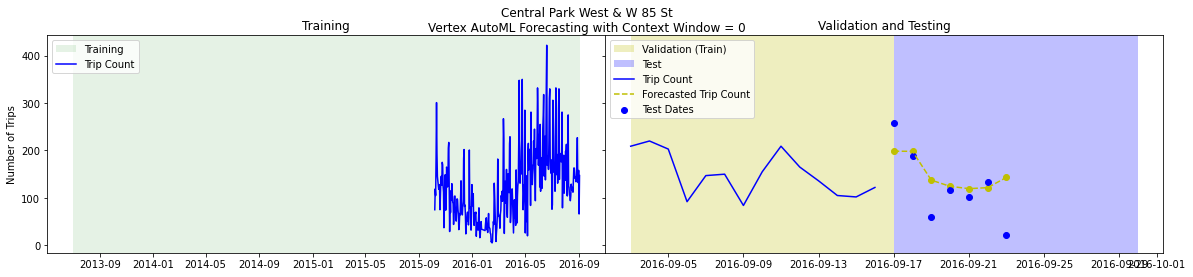

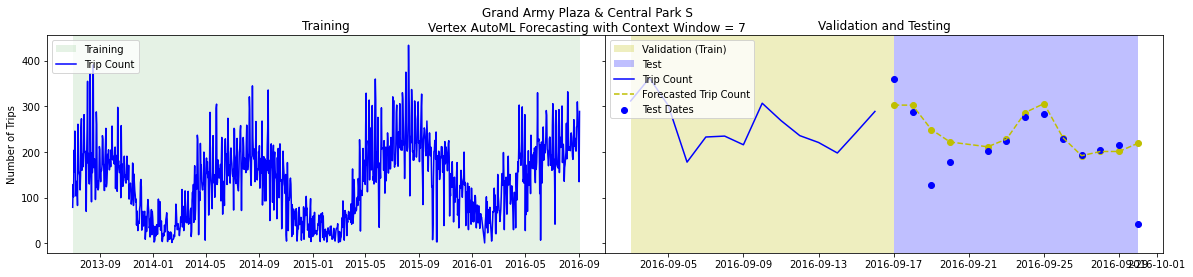

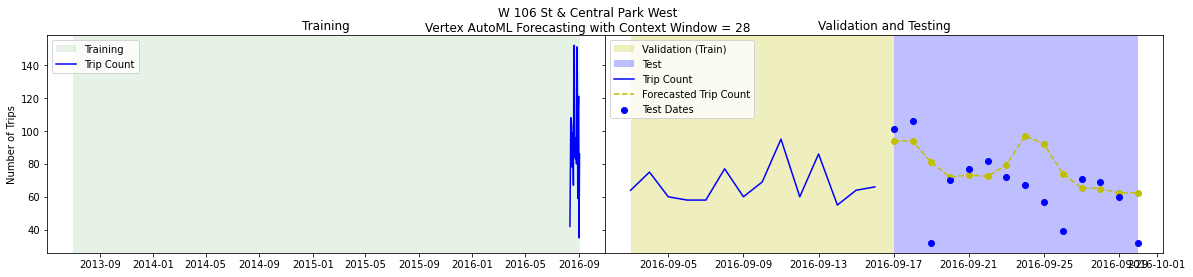

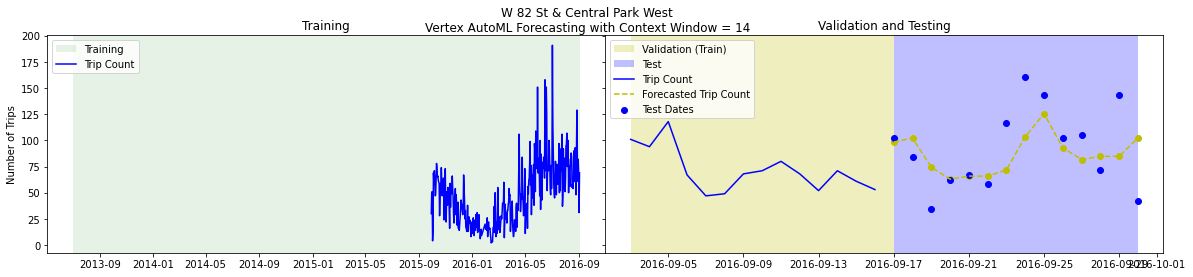

In [108]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[1].plot(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nVertex AutoML Forecasting with Context Window = {fit_testdf['CW'].iloc[0]}")

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"